In [1]:
import utils
import graphs
import torch
import torch_geometric
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit import Chem
import functools
import numpy as np
import pandas as pd
import models
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine

def plot_specs(flatspec1, flatspec2, mol, labels=['one', 'two'], relative=True):
    f, axarr = plt.subplots(nrows=1,  ncols=2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(15, 5))
    s1, s2 = utils.decode_spec(flatspec1, lowest_intensity=0.01), utils.decode_spec(flatspec2, lowest_intensity=0.01)
    if relative:
        s1_intensities = s1[:, 1] / s1[:, 1].max()
        s2_intensities = s2[:, 1] / s2[:, 1].max()
    else:
        s1_intensities = s1[:, 1]
        s2_intensities = s2[:, 1]
    axarr[0].vlines(s1[:, 0], ymin=0, ymax=s1_intensities, color='red', label=labels[0])
    axarr[0].vlines(s2[:, 0], ymin=-s2_intensities, ymax=0, color='blue', label=labels[1])
    axarr[0].legend()
    axarr[1].imshow(Draw.MolToImage(mol))
    axarr[1].axis('off')
    axarr[0].set_title(f'Mass: {ExactMolWt(mol)}| {utils.get_fragmentation_level(mol, flatspec1)} | {utils.get_featurized_fragmentation_level(mol, flatspec1)}')
    
MOL_REPS = {
    'mlp': utils.fingerprint,
    'graphconv': graphs.mol_to_torch_geom,
    'bert': utils.chemberta_tokenize,
    'egnn': functools.partial(graphs.mol_to_torch_geom, add_positions=True)
}

MODEL_CLASSES = {
    'mlp': models.Mol2SpecSimple,
    'graphconv': models.Mol2SpecGraph,
    'egnn': models.Mol2SpecEGNN,
    'bert': models.Mol2SpecBERT,
}

def setup_data(model_type):
    parser = utils.gnps_parser_3d if model_type == 'egnn' else utils.gnps_parser
    if model_type == 'egnn':
        files = ('data/pos_processed_gnps_shuffled_with_3d_validation.tsv', 'data/pos_processed_gnps_shuffled_with_3d_validation.sdf')
    else:
        files = 'data/pos_processed_gnps_shuffled_with_3d_validation.tsv'
    use_cache = model_type in ['egnn', 'graphconv']
    print('Loading data')
    data = utils.Mol2SpecDataset(
            f'{model_type}_gnps_validation',
            files,
            parser=parser,
            mol_representation=MOL_REPS[model_type],
            use_cache=use_cache
            )
    
    dataloader = torch_geometric.loader.DataLoader if model_type in ['egnn', 'graphconv'] else torch.utils.data.DataLoader
    return data, dataloader(data, batch_size=len(data))

def load_model(model_path, model_type):
    saved_state = torch.load(model_path)
    model = MODEL_CLASSES[model_type](**saved_state['model_kwargs'])
    
    model.load_state_dict(saved_state['model_state_dict'])
    for param in model.parameters():
            param.requires_grad = False
    model.eval()
    return model

def cosine_sim(A, B, MZS):
    return 1 - np.array([cosine(A[i, :] * MZS, B[i, :] * MZS) for i in range(A.shape[0])])
    
def eval_samples(pred, true):
    MZS = np.vstack([np.arange(utils.MAX_MZ) for _ in range(pred.shape[0])])
    int_mse = ((pred[:, :utils.MAX_MZ] - true[:, :utils.MAX_MZ])**2).mean(axis=1)
    decoded_pred = 10 ** pred[:, :utils.MAX_MZ] -1
    decoded_true = 10 ** true[:, :utils.MAX_MZ] -1
    decoded_pred[decoded_pred < 0] = 0
    #decoded_pred /= decoded_pred.max(axis=1)[:, None]
    
    #decoded_pred[decoded_pred <= 0.1] = 0
    #decoded_true[decoded_true <= 0.1] = 0
    cos_sim = cosine_sim(decoded_pred, decoded_true, np.arange(utils.MAX_MZ))
    mz_true = MZS + 10 ** true[:, utils.MAX_MZ:] - 1
    mz_pred = MZS + 10 ** pred[:, utils.MAX_MZ:] - 1
    ppms = []
    for i in range(pred.shape[0]):
        mz_true_ = mz_true[i, true[i, :utils.MAX_MZ] > 0.01]
        mz_pred_ = mz_pred[i, true[i, :utils.MAX_MZ] > 0.01]
        ppm = (abs(mz_pred_ - mz_true_) / (mz_true_) * 10**6).mean()
        ppms.append(ppm)
    return int_mse, cos_sim, np.array(ppms)

def evaluate(model_path, model_type, sample_plots=10, plot=True):
    model = load_model(model_path, model_type)
    
    data, dataloader = setup_data(model_type)
    for inputs, targets in dataloader:
        preds = model(inputs)        
        preds = preds.numpy()
        targets = targets.numpy()
        int_mse, cos_sim, ppm = eval_samples(preds, targets)
    plt.figure()
    plt.hist(int_mse)
    plt.title('Intensity MSE')
    plt.figure()
    plt.hist(cos_sim)
    plt.title('Cosine similarity')
    plt.figure()
    plt.hist(ppm)
    plt.title('PPM')
    if plot:
        

        argsort = np.argsort(1 - cos_sim)
        for idx in argsort[:sample_plots].tolist():
            plot_specs(targets[idx, :], preds[idx, :], data.molecules[idx], labels=['true', 'pred'])
            plt.title('BEST')

        for idx in argsort[-sample_plots:].tolist():
            try:
                plot_specs(targets[idx, :], preds[idx, :], data.molecules[idx], labels=['true', 'pred'])
                plt.title('WORST')
            except:
                pass

        for idx in np.random.choice(argsort, size=sample_plots):
            try:
                plot_specs(targets[idx, :], preds[idx, :], data.molecules[idx], labels=['true', 'pred'])
                plt.title('RANDOM')
            except:
                pass
    
    return pd.DataFrame([[model_type, model_path, int_mse.mean(), ppm.mean(), cos_sim.mean()]], 
                        columns=['model_type', 'model_path', 'intensity_mse', 'ppm', 'cosine_similarity'])
    
        
#evaluate('runs/model_graphconv_hdim_1024_layers_3_bs_64_adam/best_checkpoint.pt', 'graphconv', plot=False)     

In [2]:
3

3

Loading data
Cache found, loading dataset


/tmp/ipykernel_15054/3911727000.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(nrows=1,  ncols=2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(15, 5))


,model_type,model_path,intensity_mse,ppm,cosine_similarity
0,egnn,runs/model_egnn_hdim_1024_layers_2_bs_64_adam_...,0.000087,612.208084,0.309233


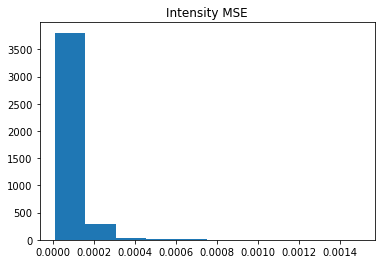

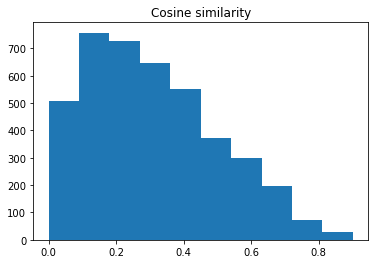

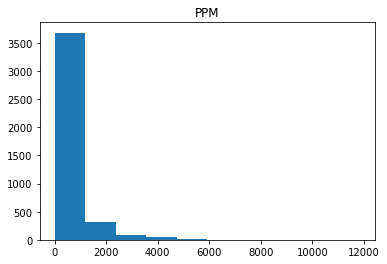

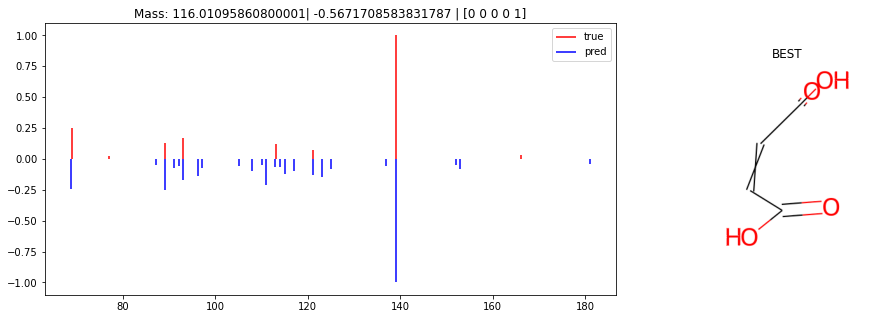

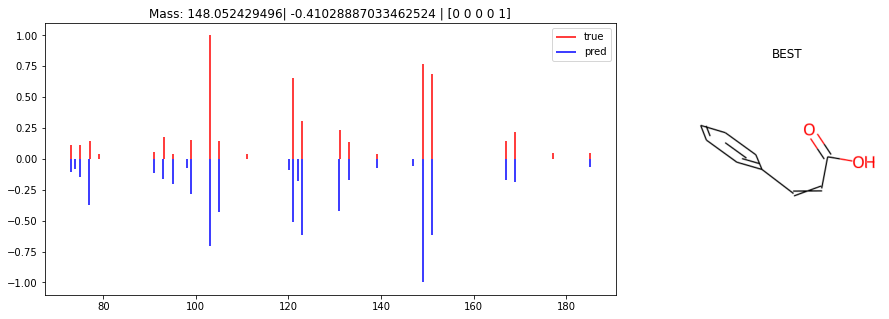

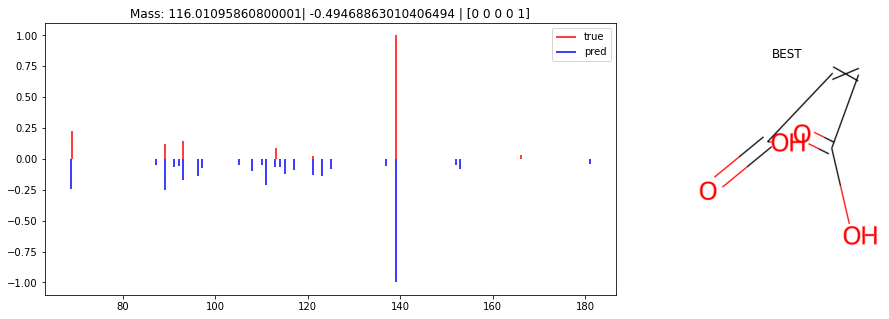

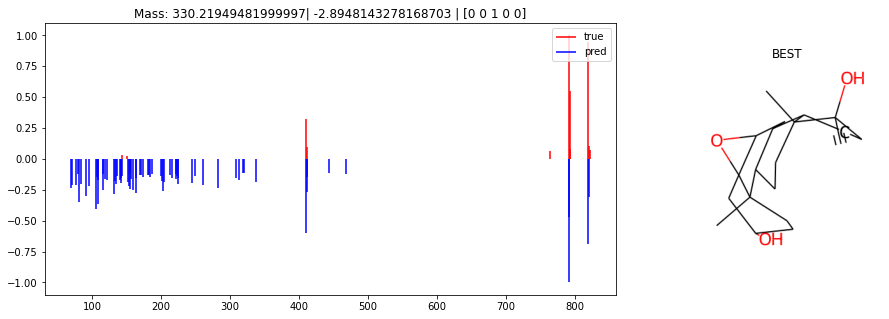

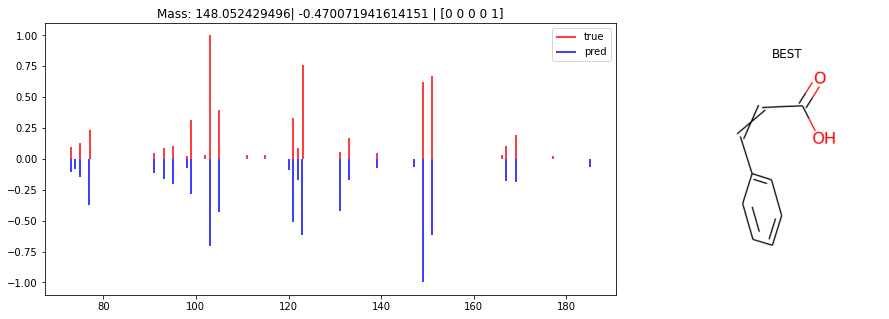

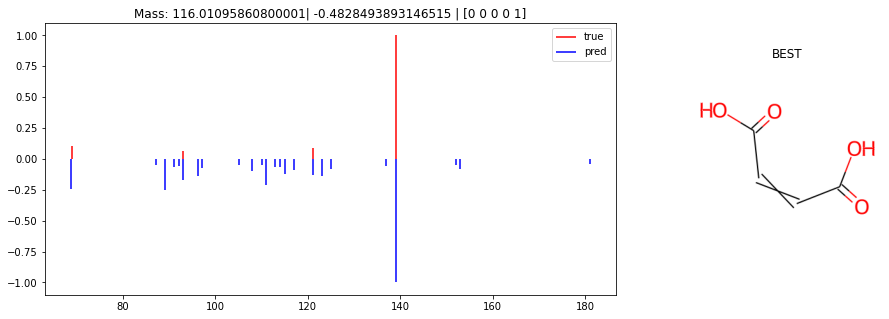

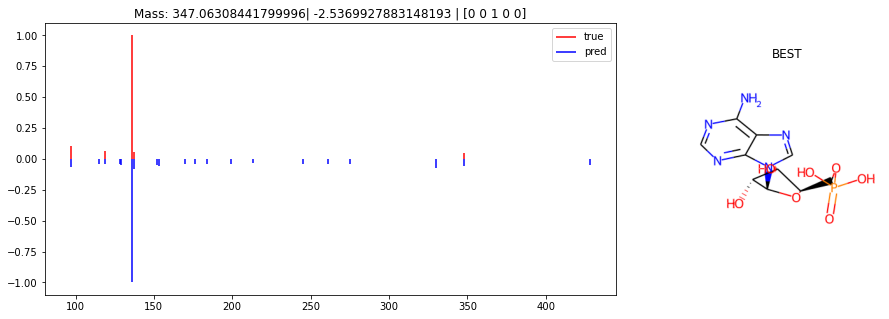

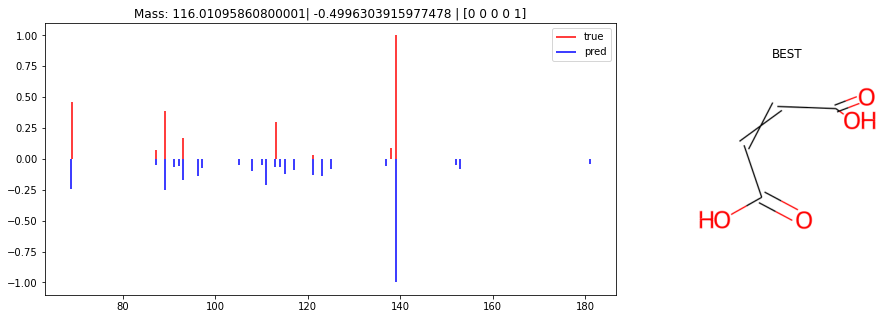

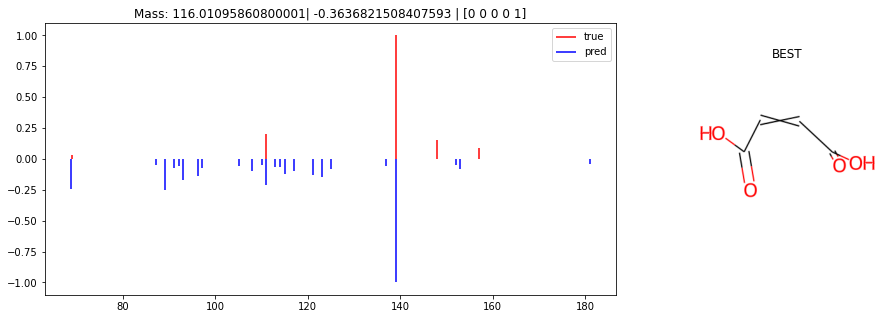

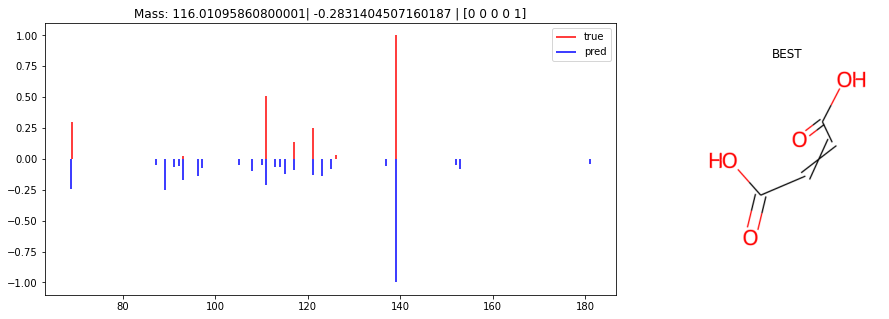

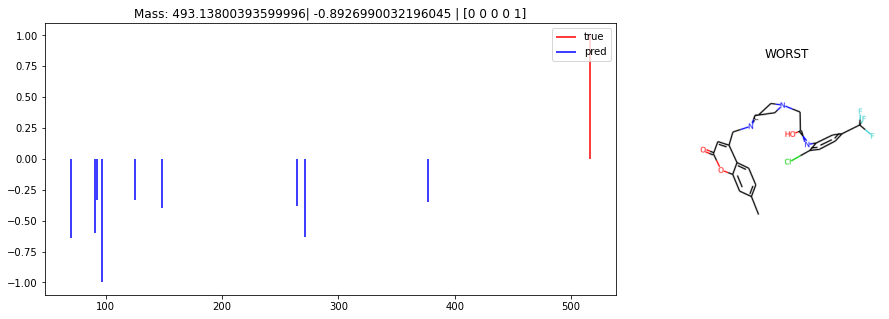

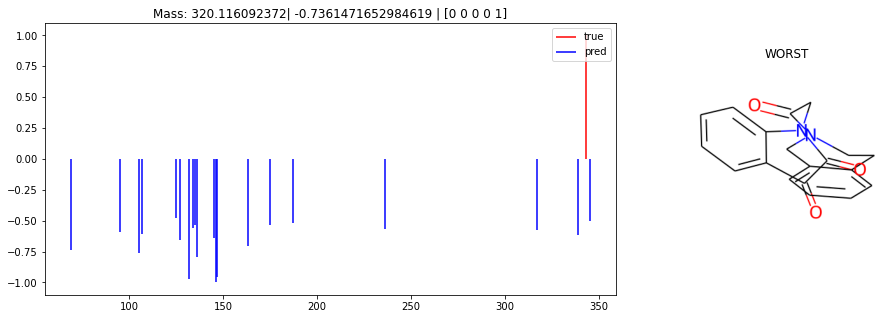

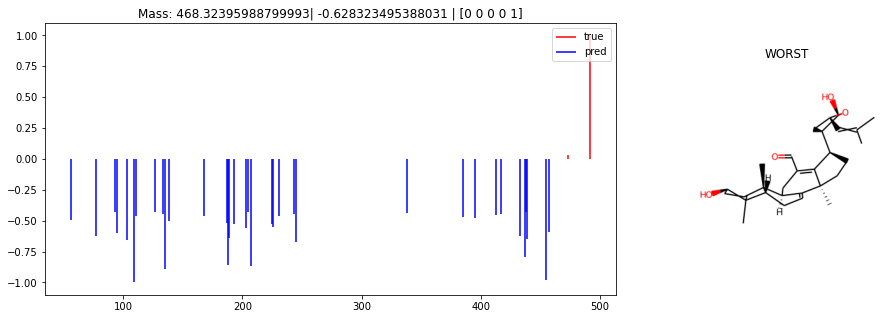

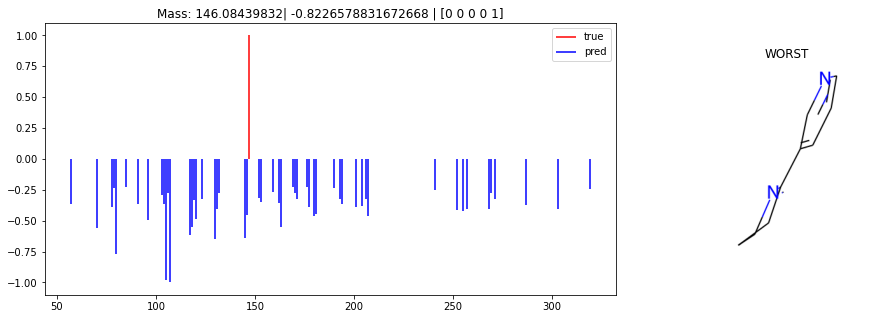

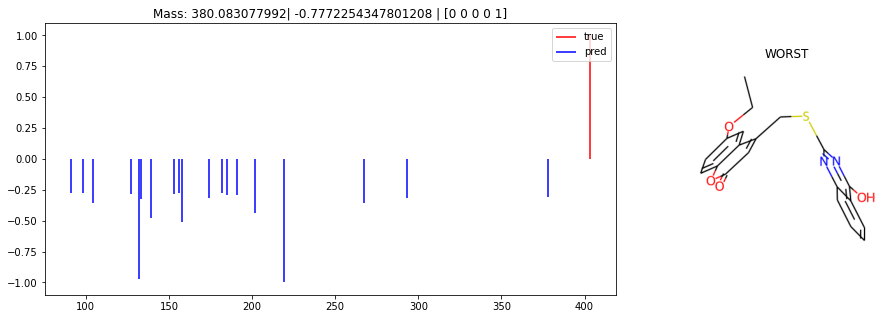

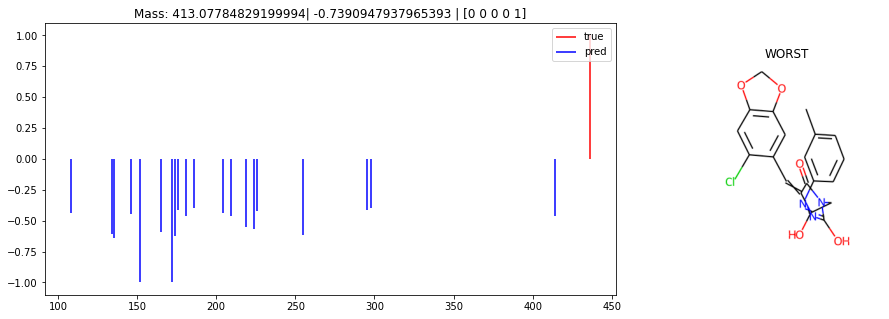

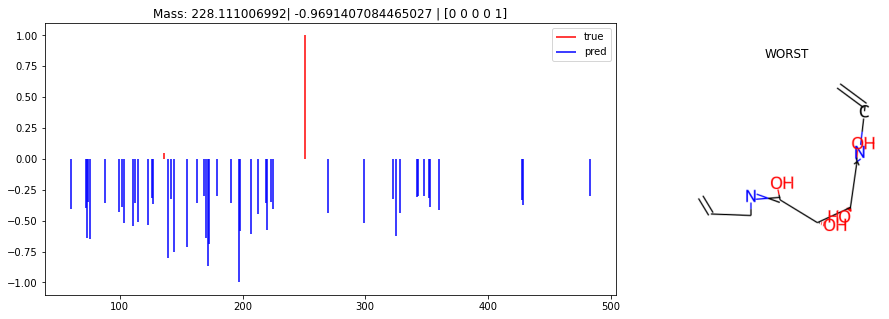

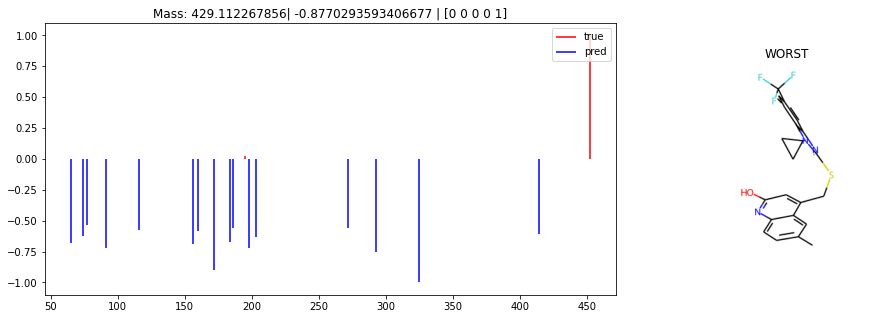

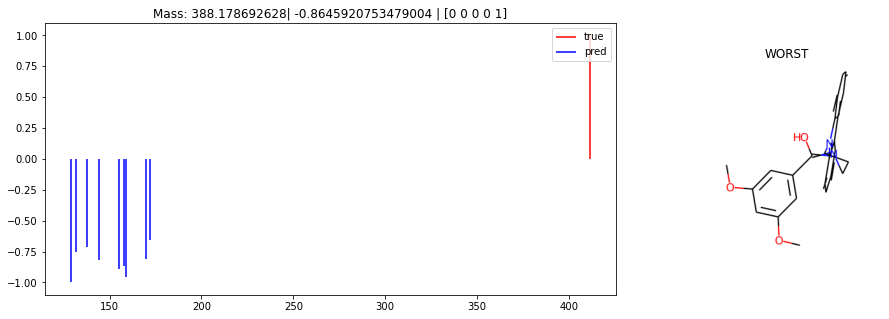

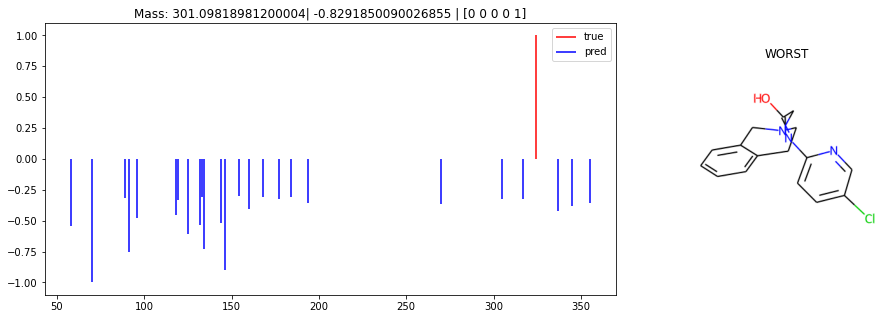

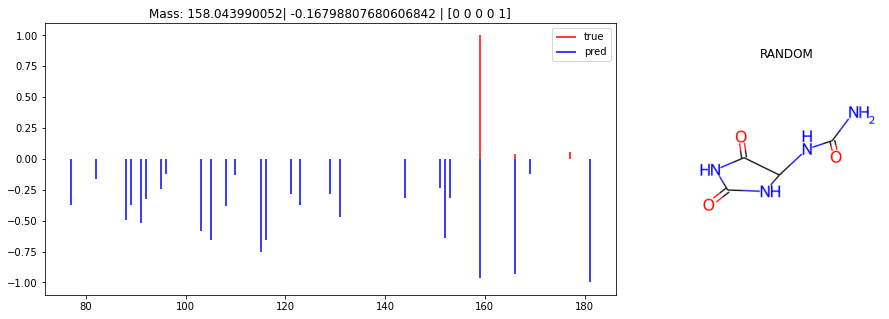

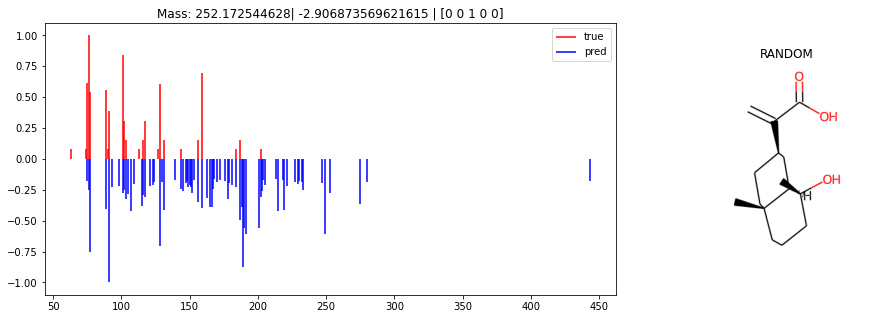

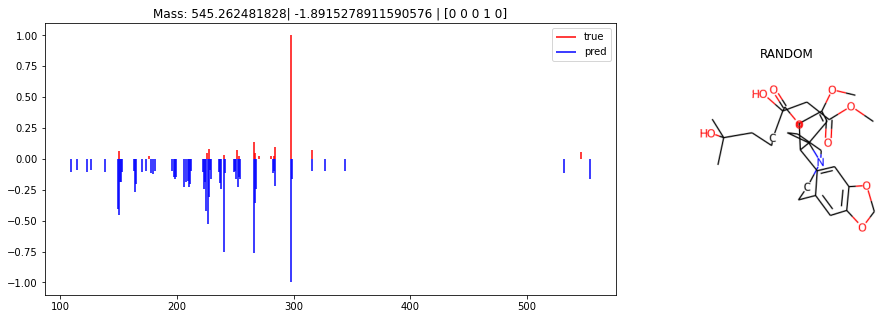

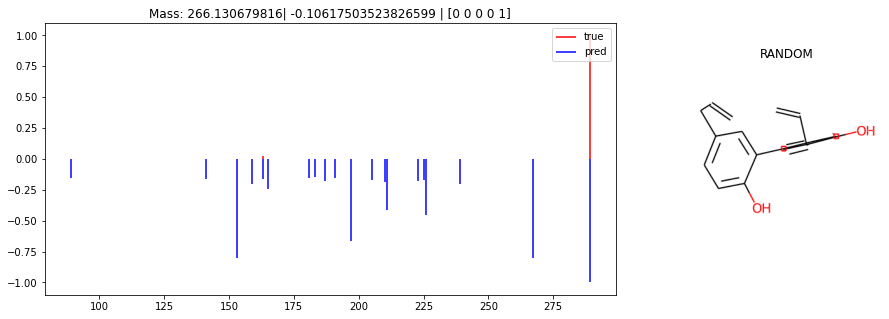

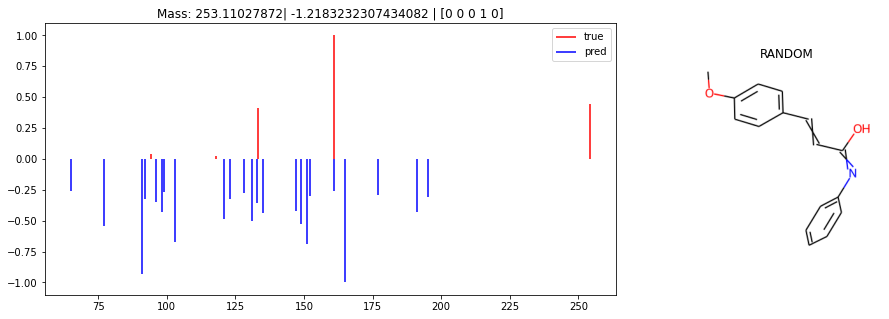

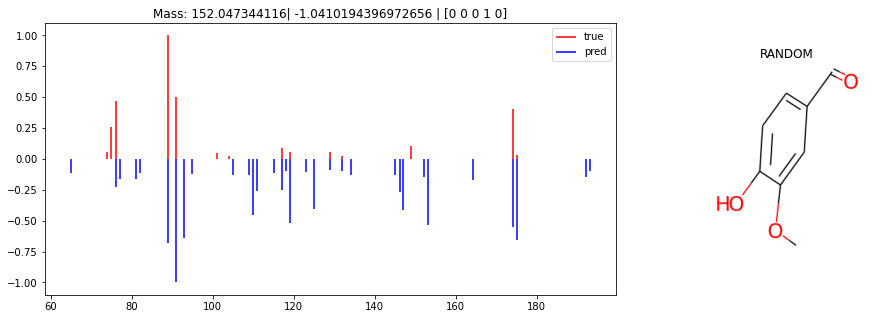

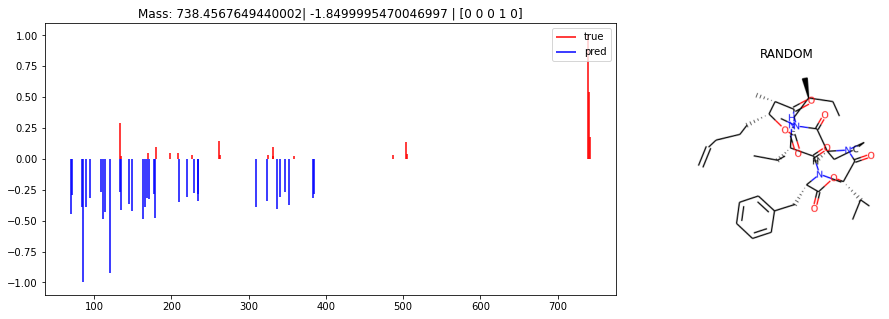

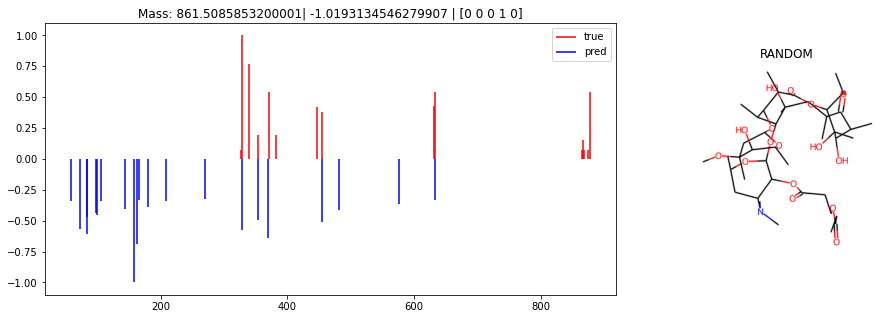

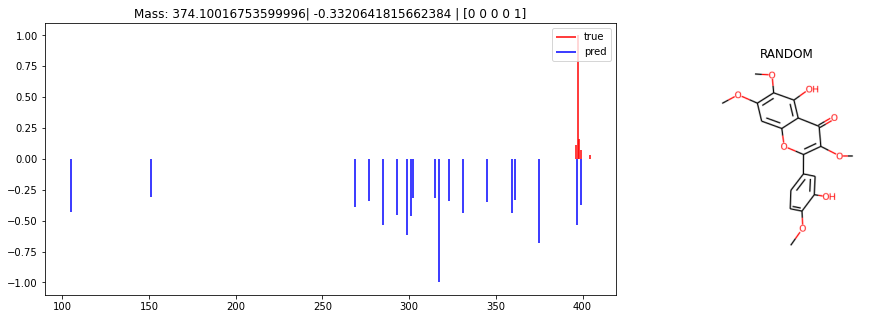

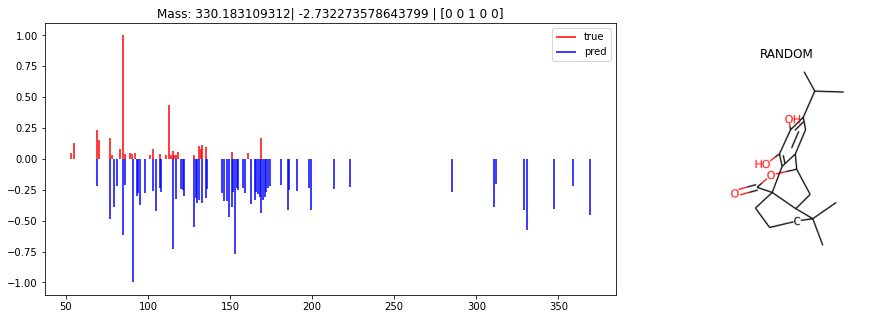

In [4]:
evaluate('runs/model_egnn_hdim_1024_layers_2_bs_64_adam_prod/best_checkpoint.pt', 'egnn', plot=True)     